## Нормализация и визуализация данных HepaRG
Данный блокнот демонстрирует рабочий процесс анализа данных секвенирования транскриптома клеточной линии HepaRG от чтения `.quant`-файлов до получения TPM‑матрицы и визуализации (boxplot, PCA).


### 1. Импорт библиотек

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from typing import List

### 2. Настройка путей и сбор файлов

In [2]:
# Путь к директории с результатами oarfish
quant_dir = Path("data/quant")
quant_files = sorted(quant_dir.glob("*.quant"))
print(f"Найдено {len(quant_files)} файлов `.quant` в {quant_dir}")

Найдено 9 файлов `.quant` в data/quant


### 3. Функции загрузки и объединения данных

In [3]:
def load_quant(file_path: Path) -> pd.DataFrame:
    """
    Загружает один .quant файл, извлекает колонки c названием транскрипта, длиной и числом ридов.

    Parameters:
    - file_path: Path — путь к файлам .quant.

    Returns:
    - pd.DataFrame с индексом 'tname' и колонками:
      - length_<sample>: длина транскрипта (int)
      - reads_<sample>: число прочтений (int)
    """
    sample = file_path.stem
    df = pd.read_csv(file_path, sep="\t", usecols=["tname", "len", "num_reads"] )
    df = df.rename(columns={
        "len": f"length_{sample}",
        "num_reads": f"reads_{sample}"
    }).set_index("tname")
    return df


def merge_quant_tables(files: List[Path]) -> pd.DataFrame:
    """
    Объединяет несколько DataFrame, созданных функцией load_quant, в единую таблицу.
    При этом разбирает столбец 'tname' на метаданные транскрипта.

    Parameters:
    - files: List[Path] — список путей к .quant файлам.

    Returns:
    - pd.DataFrame, содержащий столбцы:
      [ENST, ENSG, gene_name, tx_length, biotype, reads_<sample1>, ..., reads_<sampleN>]
    """
    tables = [load_quant(f) for f in files]
    merged = pd.concat(tables, axis=1)
    merged = merged.reset_index()
    # Разбираем tname
    cols = ["ENST","ENSG","OTTHUMG","OTTHUMT","transcript","gene_name","tx_length","biotype","_drop"]
    merged[cols] = merged["tname"].str.split("|", expand=True)
    merged = merged.drop(columns=["OTTHUMG","OTTHUMT","_drop","tname"])
    # Упорядочиваем колонки
    read_cols = [c for c in merged.columns if c.startswith("reads_")]
    result = merged[["ENST","ENSG","gene_name","tx_length","biotype"] + read_cols]
    return result

# Загружаем и объединяем
df_merged = merge_quant_tables(quant_files)

### 4. Создание матриц экспрессии

4.1 Создание TPM-нормализованной матрицы  (для построения boxplot и PCA-анализа)

In [4]:
# Преобразуем длину транскрипта в числовой тип
df_merged['tx_length'] = pd.to_numeric(df_merged['tx_length'], errors='coerce')

# Группируем по гену и суммируем риды; длину — максимальную
reads_cols = [col for col in df_merged.columns if col.startswith('reads_')]
gene_grouped = (
    df_merged
    .groupby('gene_name', as_index=False)
    .agg({**{col: 'sum' for col in reads_cols}, 'tx_length': 'max'})
)

# Вычисляем RPK и TPM
rpk = gene_grouped[reads_cols].div(gene_grouped['tx_length'] / 1e3, axis=0)
scale_factors = rpk.sum(axis=0) / 1e6
tpm_matrix = rpk.div(scale_factors, axis=1)

# Сохраняем TPM-матрицу
tpm = tpm_matrix.copy()
tpm.insert(0, 'gene_name', gene_grouped['gene_name'])
tpm.to_csv('expression_matrix_TPM.csv', index=False)
print("Сохранена матрица expression_matrix_TPM.csv")

Сохранена матрица expression_matrix_TPM.csv


4.2 Создание матрицы сырых чтений и файла coldata, содержащего метаданные образцов, для дальнейшего анализа в R пакетами DEseq2 и EdgeR, а также создание 

In [5]:
# Формируем raw counts таблицу (без округления)
raw_counts = gene_grouped[['gene_name'] + reads_cols]
raw_counts.columns = ['GeneName'] + [col.replace('reads_', '') for col in reads_cols]
# Упорядочиваем столбцы: NonDiff → Diff → Ind
desired_order = ['GeneName'] + [f"NonDiff_{i}" for i in (1,2,3)] + [f"Diff_{i}" for i in (1,2,3)] + [f"Ind_{i}" for i in (1,2,3)]
raw_counts = raw_counts[desired_order]
raw_counts.to_csv('raw_counts_matrix.tsv', sep='	', index=False)
print("Сохранена матрица raw_counts_matrix.tsv")

# Автоматическая генерация файла с информацией о группах
condition_map = {'NonDiff':'Undifferentiated', 'Diff':'Differentiated', 'Ind':'Induced'}
coldata = pd.DataFrame({
    'sample': raw_counts.columns.tolist()[1:],
    'condition': [condition_map[s.split('_')[0]] for s in raw_counts.columns[1:]]
})
coldata.to_csv('coldata.csv', index=False)
print("Сохранён файл coldata.csv")

Сохранена матрица raw_counts_matrix.tsv
Сохранён файл coldata.csv


### 5. Подготовка данных для визуализации

In [6]:
# Убираем префикс 'reads_' и переименовываем колонки
sample_map = {col: col.replace('reads_', '') for col in reads_cols}
# Переименование, фильтрация и лог-преобразование:
log_tpm = (
    tpm.rename(columns=sample_map)
       .set_index('gene_name')
       # Фильтруем по среднему TPM >= 1
       .loc[lambda df: df.mean(axis=1) >= 1]
       # Добавляем псевдоконстанту перед логированием, чтобы избежать 0
       .add(1)
       # Применяем log2
       .pipe(np.log2)
)

### 6. Boxplot распределения экспрессии

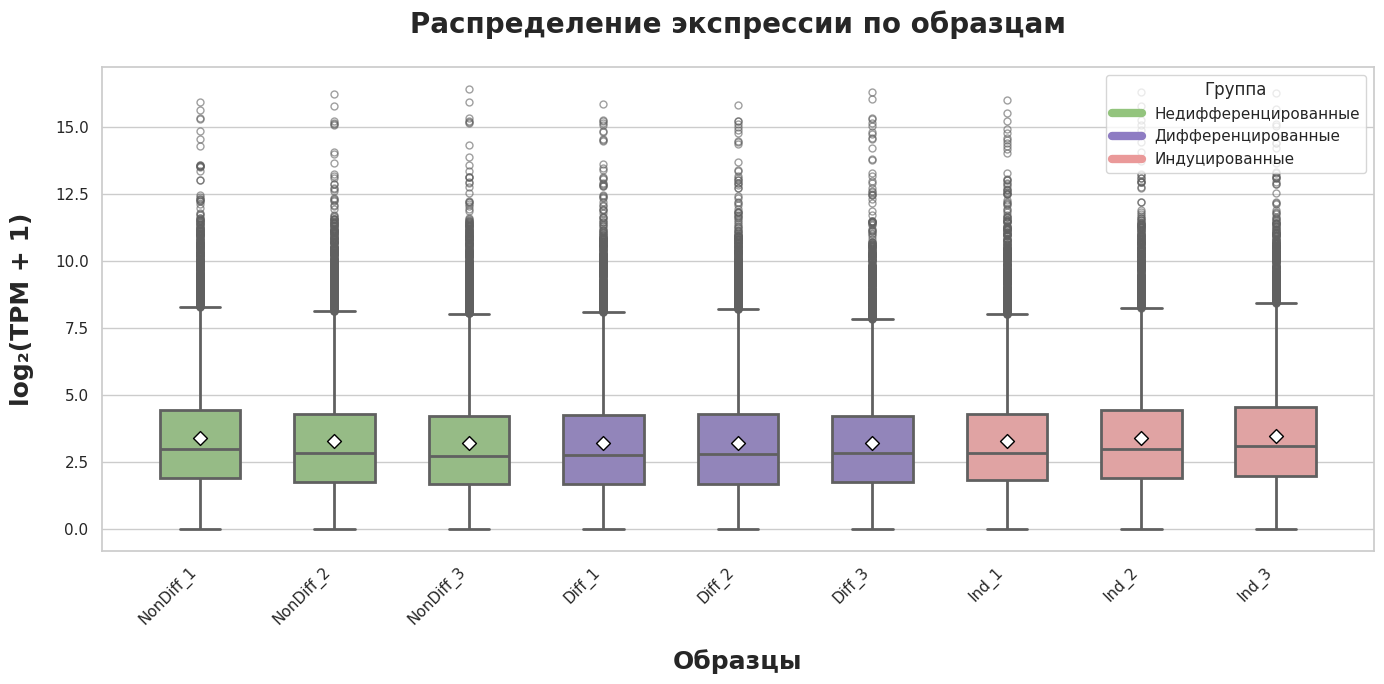

In [7]:
# Задаём стили
sns.set(style='whitegrid')
# Цвета для групп
colors = {'NonDiff': '#93C47D', 'Diff': '#8E7CC3', 'Ind': '#EA9999'}
# Определяем группы и задаём порядок: NonDiff -> Diff -> Ind
group_order = ['NonDiff', 'Diff', 'Ind']
# Перемещаем столбцы в нужном порядке
ordered_cols = [col for grp in group_order for col in log_tpm.columns if col.startswith(grp)]
log_tpm_ord = log_tpm[ordered_cols]
# Формируем палитру в порядке колонок
palette = [colors[col.split('_')[0]] for col in log_tpm_ord.columns]

plt.figure(figsize=(14,7))
ax = sns.boxplot(
    data=log_tpm_ord,
    palette=palette,
    order=log_tpm_ord.columns,
    width=0.6,
    linewidth=2,
    flierprops={'marker': 'o', 'alpha': 0.6, 'markersize': 5}
)
# Добавляем средние значения
means = log_tpm_ord.mean()
for idx, mean in enumerate(means):
    ax.scatter(
        idx, mean,
        marker='D',
        s=50,
        edgecolor='black',
        facecolor='white',
        zorder=10
    )
# Настройка подписи осей и заголовка
plt.ylabel("log₂(TPM + 1)", 
          fontsize=18, 
          fontweight='semibold', 
          labelpad=15)
plt.xlabel("Образцы", 
          fontsize=18, 
          fontweight='semibold', 
          labelpad=15)
plt.title("Распределение экспрессии по образцам", 
          fontsize=20, 
          fontweight='bold', 
          pad=25)
plt.xticks(rotation=45, ha='right')
# добавляем легенду
handles = [plt.Line2D([0], [0], color=colors[grp], lw=6) for grp in group_order]
labels = ['Недифференцированные', 'Дифференцированные', 'Индуцированные']
ax.legend(handles, labels, title='Группа', loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

### 7. PCA-анализ

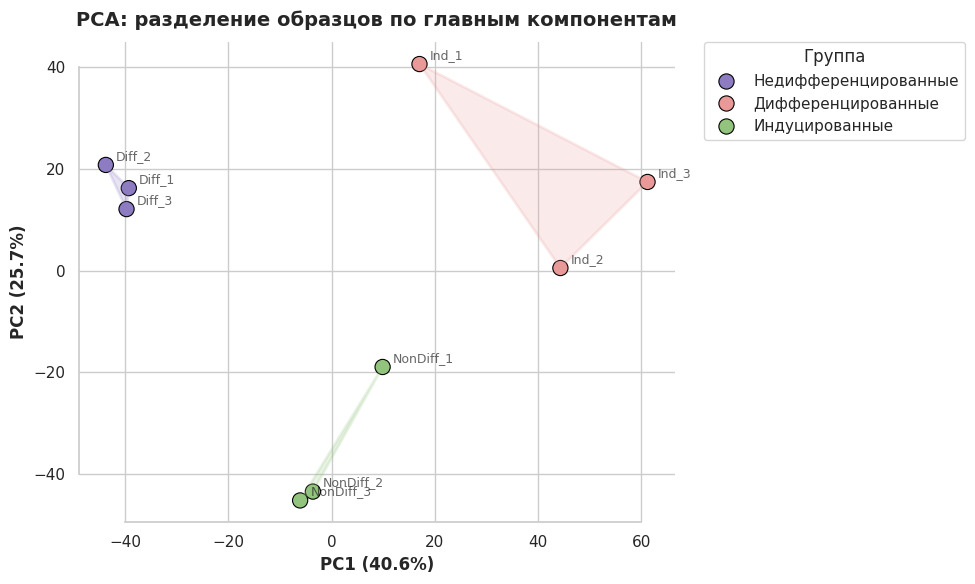

In [8]:
import numpy as np
from scipy.spatial import ConvexHull       # для расчёта выпуклой оболочки
from matplotlib.patches import Polygon
# 1. Извлечение групповой метки
groups = log_tpm.columns.str.extract(r'(NonDiff|Diff|Ind)')[0]

# 2. PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(log_tpm.T)

# 3. Настройка палитры и стиля
palette = {
    'NonDiff': '#93C47D',
    'Diff':    '#8E7CC3',
    'Ind':     '#EA9999'
}
sns.set_style("whitegrid")  # чистый фон 

# 4. Рисуем scatterplot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x=pca_coords[:, 0], y=pca_coords[:, 1],
    hue=groups, palette=palette,
    s=120, edgecolor='black', linewidth=0.8
)

# 5. Добавляем выпуклые оболочки для каждого кластера
for grp in palette:
    idx = np.where(groups == grp)[0]
    if len(idx) >= 3:
        pts = pca_coords[idx, :]
        hull = ConvexHull(pts)
        polygon = Polygon(
            pts[hull.vertices],
            facecolor=palette[grp], edgecolor=palette[grp],
            alpha=0.2, linewidth=2
        )
        ax.add_patch(polygon)

# 6. Подписываем образцы
for i, sample in enumerate(log_tpm.columns):
    ax.text(
        pca_coords[i, 0] + 2, pca_coords[i, 1] + 1,
        sample, fontsize=9, alpha=0.7
    )

# 7. Оформление осей и заголовка
ax.set_xlabel(
    f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
    fontweight='bold'
)
ax.set_ylabel(
    f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
    fontweight='bold'
)
ax.set_title(
    "PCA: разделение образцов по главным компонентам",
    fontsize=14, fontweight='bold', pad=12
)

sns.despine(trim=True)

# Кастомизация легенды
legend_labels = {
    'NonDiff': 'Недифференцированные',
    'Diff':    'Дифференцированные',
    'Ind':     'Индуцированные'
}
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles,
    [legend_labels[grp] for grp in palette],
    title='Группа',
    frameon=True,
    loc='upper left',          # Якорь - верхний левый угол легенды
    bbox_to_anchor=(1.05, 1),  # Сдвиг вправо
    borderaxespad=0.
)

# Автоматическая подстройка макета
plt.tight_layout()
plt.show()

## Дополнительный функциональный анализ

Формирование файлов для подачи в программу анализа обогащения путей GSEA (Gene Set Enrichment Analysis)

### 8. Подготовка таблицы для GSEA: группировка и округление

In [9]:
# Определяем столбцы с ридами (reads_*)
reads_columns = [col for col in df_merged.columns if col.startswith('reads_')]

# Группируем по гену и суммируем риды
gene_counts = (
    df_merged
    .groupby('gene_name')[reads_columns]
    .sum()
)

# Округляем и приводим к целому типу
gene_counts_rounded = gene_counts.round().astype(int)

# Переименовываем столбцы без префикса 'reads_'
gene_counts_rounded.columns = [col.removeprefix('reads_') for col in gene_counts_rounded.columns]

# Упорядочиваем образцы по нужному порядку
desired_order = [f"{grp}_{i}" for grp in ['NonDiff','Diff','Ind'] for i in (1,2,3)]
gene_counts_rounded = gene_counts_rounded[desired_order]

### 9. Автоматизация сохранения TSV и CLS файлов для GSEA

In [10]:
# Функция для сохранения TSV-файла с данными по сравнению
def save_comparison_tsv(df: pd.DataFrame, sample_list: list, filename: str) -> None:
    """
    Сохраняет подтаблицу df по образцам sample_list в TSV-файл.

    Parameters:
    - df: pd.DataFrame — полная count-таблица с индексом gene_name.
    - sample_list: list[str] — имена столбцов для экспорта.
    - filename: str — имя выходного файла.
    """
    df[sample_list].reset_index().rename(columns={'gene_name':'GeneName'}) \
      .to_csv(filename, sep='	', index=False, encoding='utf-8')
    print(f"Сохранён TSV: {filename}")

# Настройка сравнений
gsea_comparisons = {
    'NonDiff_vs_Diff': ['NonDiff_1','NonDiff_2','NonDiff_3','Diff_1','Diff_2','Diff_3'],
    'NonDiff_vs_Ind':  ['NonDiff_1','NonDiff_2','NonDiff_3','Ind_1','Ind_2','Ind_3'],
    'Diff_vs_Ind':     ['Diff_1','Diff_2','Diff_3','Ind_1','Ind_2','Ind_3'],
}

# Генерация TSV файлов
gsea_dir = Path('gsea_files')
gsea_dir.mkdir(exist_ok=True)
for name, samples in gsea_comparisons.items():
    save_comparison_tsv(gene_counts_rounded, samples, gsea_dir/f"{name}.tsv")

# Функция для создания CLS-файлов для GSEA
def create_cls_file(sample_labels: list, class_names: list, filename: str) -> None:
    """
    Создает CLS-файл для GSEA.

    Parameters:
    - sample_labels: list[str] — последовательность меток для каждого образца.
    - class_names: list[str] — список уникальных классов.
    - filename: str — путь к файлу .cls.
    """
    with open(filename, 'w') as f:
        f.write(f"{len(sample_labels)} {len(set(sample_labels))} 1\n")
        f.write(f"# {' '.join(class_names)}\n")
        f.write(' '.join(sample_labels) + "\n")
    print(f"Сохранён CLS: {filename}")

# Генерация CLS файлов
for name, samples in gsea_comparisons.items():
    # метки класса берём из префикса до '_'
    labels = [s.split('_')[0] for s in samples]
    classes = sorted(set(labels), key=lambda x: ['NonDiff','Diff','Ind'].index(x))
    create_cls_file(labels, classes, gsea_dir/f"{name}.cls")

Сохранён TSV: gsea_files/NonDiff_vs_Diff.tsv
Сохранён TSV: gsea_files/NonDiff_vs_Ind.tsv
Сохранён TSV: gsea_files/Diff_vs_Ind.tsv
Сохранён CLS: gsea_files/NonDiff_vs_Diff.cls
Сохранён CLS: gsea_files/NonDiff_vs_Ind.cls
Сохранён CLS: gsea_files/Diff_vs_Ind.cls
